In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
new_model = pd.read_excel('YearlyData_5years.xlsx')


In [80]:
if isinstance(new_model, pd.DataFrame):
    print("my_dataframe is a Pandas DataFrame.")
else:
    print("my_dataframe is not a Pandas DataFrame.")

my_dataframe is a Pandas DataFrame.


In [81]:
new_model = new_model[::-1].reset_index(drop=True)

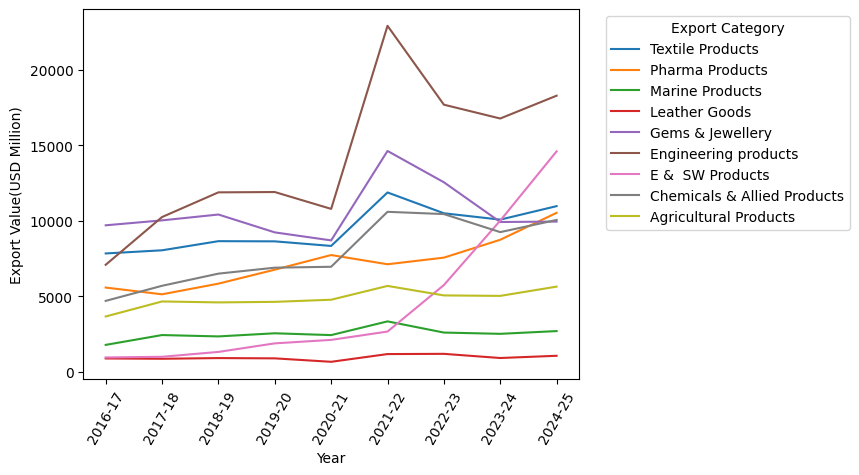

In [82]:
sns.lineplot(data=new_model, x='Year', y='Export Value(USD Million)', hue='Export Category');
plt.xticks(rotation=60);plt.legend(title="Export Category", bbox_to_anchor=(1.04,1), loc="upper left");


In [83]:
new_model[new_model['Year']=='2021-22']

,Export Category,Export Value(USD Million),Year
45,Textile Products,11865,2021-22
46,Pharma Products,7108,2021-22
47,Marine Products,3324,2021-22
48,Leather Goods,1158,2021-22
49,Gems & Jewellery,14614,2021-22
50,Engineering products,22906,2021-22
51,E & SW Products,2650,2021-22
52,Chemicals & Allied Products,10583,2021-22
53,Agricultural Products,5673,2021-22


### Note
Frequency plot
normal distribution to find anomaly
find p-value to find outlier

In [84]:
new_model.columns

Index(['Export Category', 'Export Value(USD Million)', 'Year'], dtype='object')

In [85]:
new_model1=new_model.copy(deep=True)

In [86]:
# Define the years we are working with
target_year = '2021-22'
previous_years = ['2020-21', '2019-20', '2018-19']

# Get a list of all unique categories in the DataFrame
categories = new_model1['Export Category'].unique()

# Loop through each category
for category in categories:
    
    # 1. Filter for the previous years for the current category
    previous_data = new_model1[(new_model1['Export Category'] == category) & (new_model1['Year'].isin(previous_years))]
    
    # 2. Calculate the average export value from those years
    # We add a check to ensure data exists to avoid errors
    if not previous_data.empty:
        avg_value = previous_data['Export Value(USD Million)'].mean()
        
        # 3. Update the target year's value for the current category using .loc
        new_model1.loc[
            (new_model1['Export Category'] == category) & (new_model1['Year'] == target_year), 
            'Export Value(USD Million)'] = round(avg_value)


In [87]:
new_model1[new_model1['Year'] == '2021-22']

,Export Category,Export Value(USD Million),Year
45,Textile Products,8529,2021-22
46,Pharma Products,6764,2021-22
47,Marine Products,2426,2021-22
48,Leather Goods,804,2021-22
49,Gems & Jewellery,9437,2021-22
50,Engineering products,11514,2021-22
51,E & SW Products,1755,2021-22
52,Chemicals & Allied Products,6770,2021-22
53,Agricultural Products,4652,2021-22


In [88]:
new_model[new_model['Year'] == '2021-22']

,Export Category,Export Value(USD Million),Year
45,Textile Products,11865,2021-22
46,Pharma Products,7108,2021-22
47,Marine Products,3324,2021-22
48,Leather Goods,1158,2021-22
49,Gems & Jewellery,14614,2021-22
50,Engineering products,22906,2021-22
51,E & SW Products,2650,2021-22
52,Chemicals & Allied Products,10583,2021-22
53,Agricultural Products,5673,2021-22


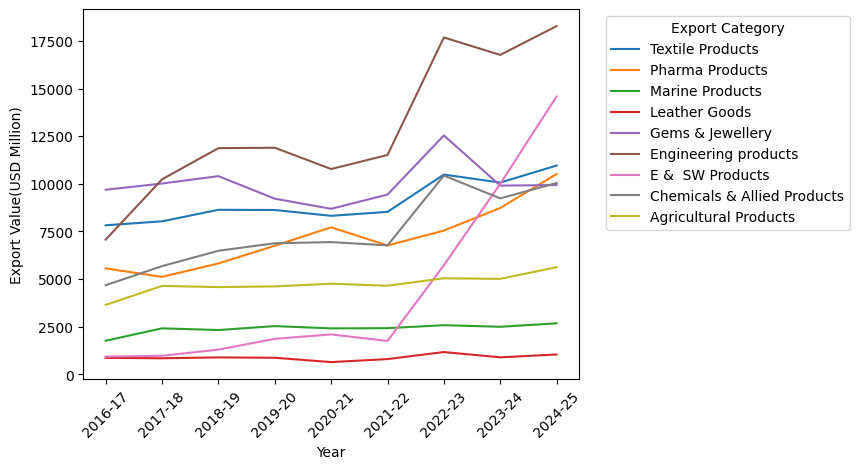

In [89]:
sns.lineplot(data=new_model1, x='Year', y='Export Value(USD Million)', hue='Export Category')
plt.xticks(rotation=45); plt.legend(title="Export Category", bbox_to_anchor=(1.04,1), loc="upper left")

### Double checking for outliers after replacing the 2021-22 data with avg of 3 year data

In [90]:
def robust_fix_spikes(g, z_thresh=3.0):
    # robust z-score via Median Absolute Deviation (less sensitive than std dev)
    vals = g['Export Value(USD Million)'].astype(float).values
    med  = np.median(vals)
    mad  = np.median(np.abs(vals - med)) or 1.0
    zrob = 0.6745 * (vals - med) / mad
    g = g.copy()
    g['z_rob'] = zrob

    # indices of outliers (could be none)
    out_idx = np.where(np.abs(zrob) > z_thresh)[0]

    for k in out_idx:
        # find nearest non-outlier neighbor on each side
        left = next((j for j in range(k-1, -1, -1) if np.abs(zrob[j]) <= z_thresh), None)
        right = next((j for j in range(k+1, len(vals)) if np.abs(zrob[j]) <= z_thresh), None)
        if left is not None and right is not None:
            new_val = np.round((vals[left] + vals[right]) / 2.0, 0)
            g.iloc[k, g.columns.get_loc('Export Value(USD Million)')] = new_val
        elif left is not None:
            g.iloc[k, g.columns.get_loc('Export Value(USD Million)')] = vals[left]
        elif right is not None:
            g.iloc[k, g.columns.get_loc('Export Value(USD Million)')] = vals[right]
        # else: leave as is (no safe neighbor)
    return g.drop(columns='z_rob')

# Apply robust fixer (COMMENT OUT if you only want to adjust 2021–22)
# df_adj = df_adj.groupby('Export Category', group_keys=False).apply(robust_fix_spikes, z_thresh=3.0)


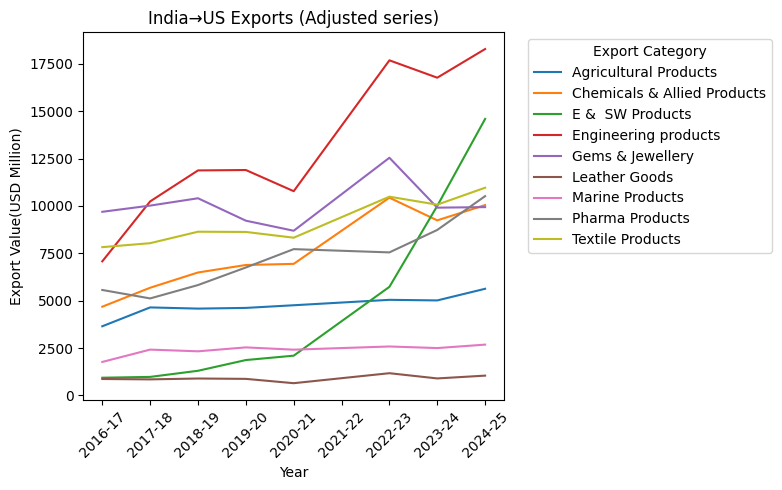

In [91]:
import matplotlib.pyplot as plt

# Build a fresh pivot AFTER adjustments
pvt = new_model_adj.pivot(index='Year', columns='Export Category', values='Export Value(USD Million)').sort_index()

plt.figure(figsize=(8,5))
for col in pvt.columns:
    plt.plot(pvt.index.astype(str), pvt[col], label=col)
plt.title("India→US Exports (Adjusted series)")
plt.xlabel("Year"); plt.ylabel("Export Value(USD Million)")
plt.xticks(rotation=45); plt.legend(title="Export Category", bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout(); plt.show()


In [92]:
df_pivot = new_model.pivot(index='Export Category', columns='Year', values='Export Value(USD Million)')
df_yoy = df_pivot.pct_change(axis=1) * 100
df_yoy = df_yoy.round(2)
df_yoy_long = df_yoy.reset_index().melt(id_vars='Export Category', var_name='Year', value_name='YoY Growth (%)')
df_yoy_long


,Export Category,Year,YoY Growth (%)
0,Agricultural Products,2016-17,NaN
1,Chemicals & Allied Products,2016-17,NaN
2,E & SW Products,2016-17,NaN
3,Engineering products,2016-17,NaN
4,Gems & Jewellery,2016-17,NaN
...,...,...,...
76,Gems & Jewellery,2024-25,0.29
77,Leather Goods,2024-25,16.50
78,Marine Products,2024-25,7.28
79,Pharma Products,2024-25,20.43


In [93]:
df_yoy_long.dropna(subset=['YoY Growth (%)'], inplace=True)
avg_yoyGrowth = df_yoy_long.groupby('Export Category').agg(Avg_yearly_growth= ('YoY Growth (%)', 'mean'))

In [94]:
avg_yoyGrowth

,Avg_yearly_growth
Export Category,
Agricultural Products,6.19125
Chemicals & Allied Products,11.35000
E & SW Products,44.55500
Engineering products,18.13250
Gems & Jewellery,2.92375
Leather Goods,6.05375
Marine Products,7.08250
Pharma Products,8.80125
Textile Products,5.29500


In [95]:
new_model2=avg_yoyGrowth.reset_index()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Agricultural Products'),
  Text(1, 0, 'Chemicals & Allied Products'),
  Text(2, 0, 'E &  SW Products'),
  Text(3, 0, 'Engineering products'),
  Text(4, 0, 'Gems & Jewellery'),
  Text(5, 0, 'Leather Goods'),
  Text(6, 0, 'Marine Products'),
  Text(7, 0, 'Pharma Products'),
  Text(8, 0, 'Textile Products')])

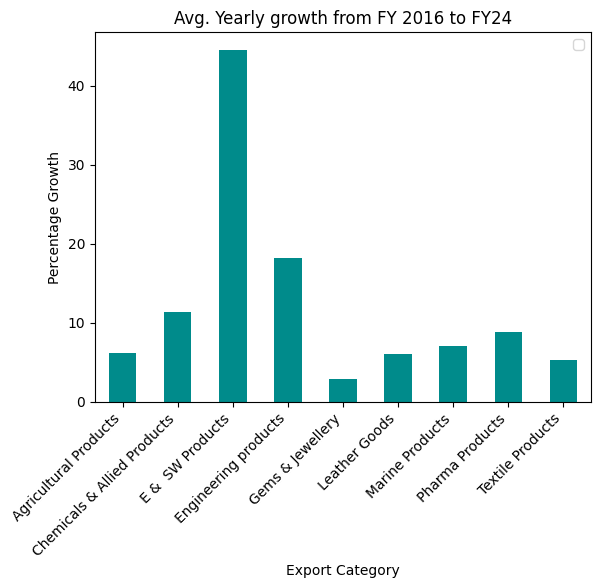

In [112]:
new_model2.plot.bar(x='Export Category', y='Avg_yearly_growth', title='Avg. Yearly growth from FY 2016 to FY24', color='darkcyan')
plt.ylabel("Percentage Growth")
plt.legend('')
plt.xticks(rotation=45, ha='right')


In [97]:
new_model1.columns

Index(['Export Category', 'Export Value(USD Million)', 'Year'], dtype='object')

In [98]:
new_model1['Year'] = new_model1['Year'].str.split('-').str[0].astype(int)

In [99]:
# 1) Baseline forecast for 2025 (no tariff variable used)
# new_model1 has columns: Year, Export Category, Export Value
#(USD Million)

import pandas as pd
from xgboost import XGBRegressor


new_model1['year_index'] = new_model1['Year'] - new_model1['Year'].min()
X = pd.get_dummies(new_model1[['year_index','Export Category']], drop_first=True)
y = new_model1['Export Value(USD Million)']

model = XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, random_state=42)
model.fit(X, y)

# Build 2025 design matrix
cats = new_model1['Export Category'].unique()
X_2025 = pd.DataFrame({'year_index':[new_model1['year_index'].max()+1]*len(cats), 'Export Category':cats})
X_2025 = pd.get_dummies(X_2025, columns=['Export Category'], drop_first=True)
X_2025 = X_2025.reindex(columns=X.columns, fill_value=0)

baseline_2025 = model.predict(X_2025)  # NO-TARIFF forecast
baseline = pd.DataFrame({'Export Category': cats, 'Pred_2025_No_Tariff': baseline_2025})

# 2) Apply tariff shock (50% tariff, 100% pass-through, category elasticities)
tariff_rate = 0.50        # 50%
pass_through = 1.00       # buyer sees full 50% increase

# Example elasticities (tune these!):
elasticity = {
    'Pharma Products': -0.3,
    'Engineering products': -1.2,
    'E & SW Products': -0.8,
    'Gems & Jewellery': -1.0,
    'Textile Products': -1.1,
    'Chemicals & Allied Products': -0.9,
    'Marine Products': -0.7,
    'Leather Goods': -1.0,
    'Agricultural Products': -0.4
}

def adj_with_tariff(row):
    e = elasticity.get(row['Export Category'], -1.0)
    qty_change = e * (tariff_rate * pass_through)   # e.g., -1.2 * 0.5 = -0.6 (−60% volume)
    return row['Pred_2025_No_Tariff'] * (1 + qty_change)

baseline['Pred_2025_With_Tariff'] = baseline.apply(adj_with_tariff, axis=1)
baseline['Estimated_Tariff_Impact ($M)'] = baseline['Pred_2025_No_Tariff'] - baseline['Pred_2025_With_Tariff']
baseline.sort_values('Estimated_Tariff_Impact ($M)', ascending=False, inplace=True)
print(baseline)


print("Total estimated losses in Million USD", baseline['Estimated_Tariff_Impact ($M)'].sum())

               Export Category  Pred_2025_No_Tariff  Pred_2025_With_Tariff  \
5         Engineering products         17968.080078            7187.232031   
6             E &  SW Products         14154.200195            7077.100098   
0             Textile Products         10702.208984            4815.994043   
4             Gems & Jewellery          9681.971680            4840.985840   
7  Chemicals & Allied Products          9808.945312            5394.919922   
1              Pharma Products         10242.491211            8706.117529   
8        Agricultural Products          7062.068359            5649.654688   
2              Marine Products          2483.937012            1614.559058   
3                Leather Goods           841.474426             420.737213   

   Estimated_Tariff_Impact ($M)  
5                  10780.848047  
6                   7077.100098  
0                   5886.214941  
4                   4840.985840  
7                   4414.025391  
1              

Text(0.5, 1.0, 'Impact Analysis')

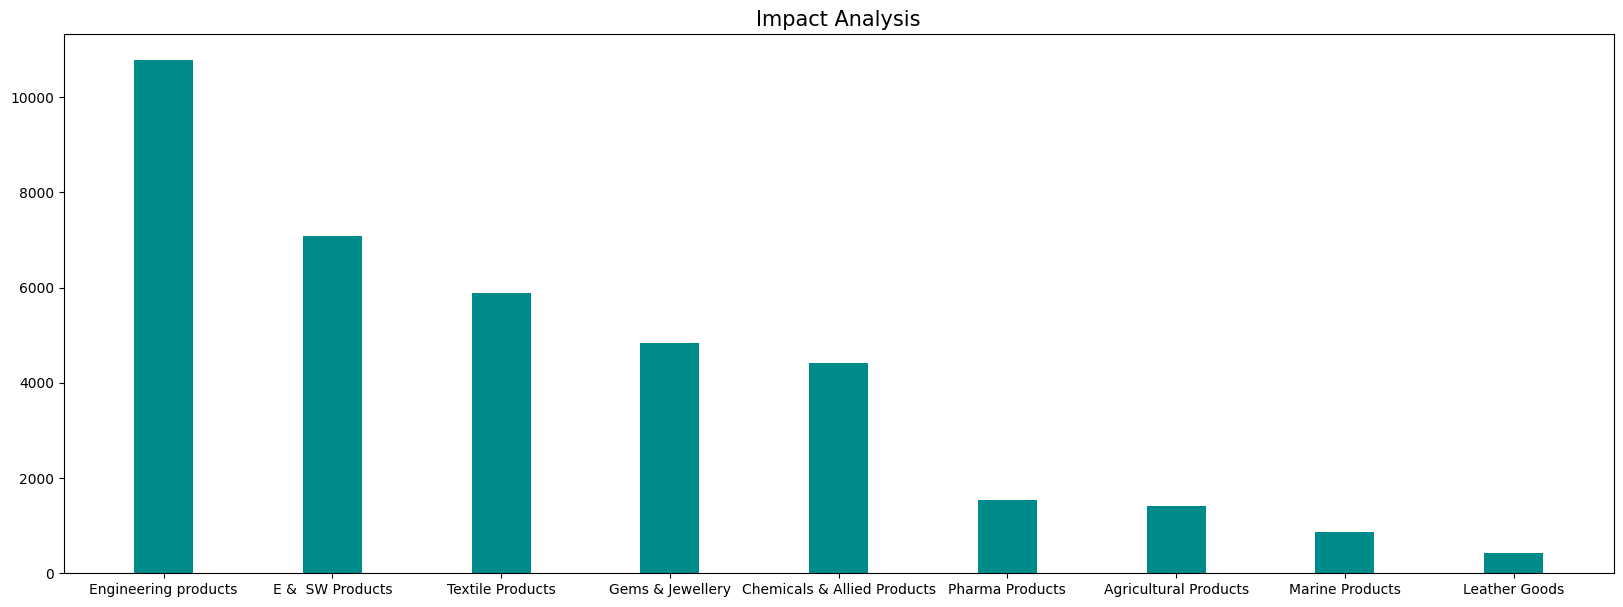

In [111]:
impact = baseline['Estimated_Tariff_Impact ($M)']
categories = baseline['Export Category']

plt.figure(figsize=(20, 7))
bar_width = 0.35
plt.bar(categories,impact, bar_width, label = 'Losses', color = 'darkcyan')
plt.xticks(fontsize=10)
plt.title("Impact Analysis", fontsize=15)

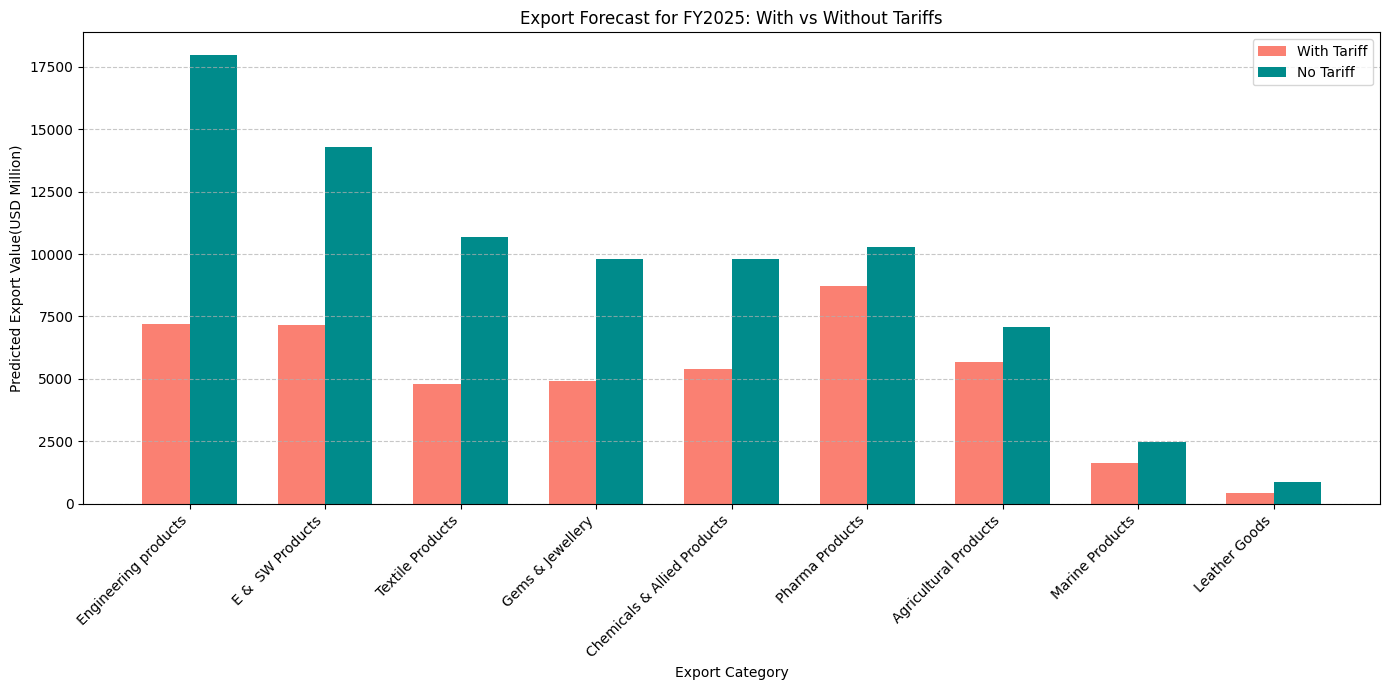

In [ ]:
# Plotting
categories = baseline['Export Category']
with_tariff = baseline['Pred_2025_With_Tariff']
no_tariff = baseline['Pred_2025_No_Tariff']

plt.figure(figsize=(14, 7))
bar_width = 0.35
index = range(len(categories))

plt.bar(index, with_tariff, bar_width, label='With Tariff', color='salmon')
plt.bar([i + bar_width for i in index], no_tariff, bar_width, label='No Tariff', color='darkcyan')

plt.xlabel('Export Category')
plt.ylabel('Predicted Export Value(USD Million)')
plt.title('Export Forecast for FY2025: With vs Without Tariffs')
plt.xticks([i + bar_width / 2 for i in index], categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)



In [ ]:
# --- Setup ---
import pandas as pd
from xgboost import XGBRegressor
import numpy as np



# Baseline model: XGBoost (no tariff feature—clean trend + category effects)
new_model1 = new_model1.sort_values(['Export Category','Year'])
new_model1['year_index'] = new_model1['Year'] - new_model1['Year'].min()
X = pd.get_dummies(new_model1[['year_index','Export Category']], drop_first=True)
y = new_model1['Export Value(USD Million)']

model = XGBRegressor(
    n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9, random_state=42
)
model.fit(X, y)

# Baseline 2025 prediction for Textile Products
target = 'Textile Products'
X_2025 = pd.DataFrame({'year_index':[new_model1['year_index'].max()+1], 'Export Category':[target]})
X_2025 = pd.get_dummies(X_2025, columns=['Export Category'], drop_first=True)
X_2025 = X_2025.reindex(columns=X.columns, fill_value=0)
baseline_2025 = float(model.predict(X_2025))

print(f"Baseline 2025 (No Tariff) for {target}: ${baseline_2025:,.0f}M")

# Tariff shock + absorption levers (SCENARIOS)
# Elasticity for textiles (tune/range-test): 
E = -1.1

def project_with_levers(
    baseline, 
    tariff_rate=0.50,
    absorb=0.20,                 # 20% absorbed in margin
    rebate_rate=0.07,            # RoSCTL mid-point ~7% for apparel/made-ups
    cost_savings_total=0.21,     # vendor(0.04)+logistics(0.10)+forecasting(0.07) example
    pass_to_price=0.50,          # pass half of those savings to the buyer
    demand_uplift=0.12,          # loyalty+bundling+marketing+customization uplift ~12%
    elasticity=E
):
    net_tariff_to_price = tariff_rate * (1 - absorb)
    effective_price_change = net_tariff_to_price - rebate_rate - pass_to_price*cost_savings_total
    qty_change = elasticity * effective_price_change
    value = baseline * (1 + qty_change) * (1 + demand_uplift)
    return {
        'net_tariff_to_price': net_tariff_to_price,
        'effective_price_change': effective_price_change,
        'qty_change_pct': qty_change,
        'value_2025_with_levers': value
    }

# Tariff-only (100% pass-through, no levers) for reference
value_tariff_only = baseline_2025 * (1 + E * 0.50)  # absorb=0, no rebates, no cost pass, no demand uplift

# Three scenarios based on your playbook
scenarios = {
    'Conservative': dict(absorb=0.10, rebate_rate=0.06, cost_savings_total=0.12, pass_to_price=0.40, demand_uplift=0.05),
    'Base Case'   : dict(absorb=0.20, rebate_rate=0.07, cost_savings_total=0.21, pass_to_price=0.50, demand_uplift=0.12),
    'Aggressive'  : dict(absorb=0.30, rebate_rate=0.082, cost_savings_total=0.28, pass_to_price=0.60, demand_uplift=0.20)
}

rows = []
for name, params in scenarios.items():
    out = project_with_levers(baseline_2025, **params, elasticity=E)
    rows.append({
        'Scenario': name,
        'Baseline_2025_NoTariff ($M)': round(baseline_2025,2),
        'TariffOnly_2025 ($M)': round(value_tariff_only,2),
        'With_Levers_2025 ($M)': round(out['value_2025_with_levers'],2),
        'Absorbed_vs_TariffOnly ($M)': round(out['value_2025_with_levers'] - value_tariff_only,2),
        'Net_Price_Change_%': round(out['effective_price_change']*100,2),
        'Quantity_Change_%': round(out['qty_change_pct']*100,2)
    })

result = pd.DataFrame(rows)
print(result)


Baseline 2025 (No Tariff) for Textile Products: $6,795M
       Scenario  Baseline_2025_NoTariff ($M)  TariffOnly_2025 ($M)  \
0  Conservative                      6795.07               3057.78   
1     Base Case                      6795.07               3057.78   
2    Aggressive                      6795.07               3057.78   

   With_Levers_2025 ($M)  Absorbed_vs_TariffOnly ($M)  Net_Price_Change_%  \
0                4450.70                      1392.92                34.2   
1                5726.89                      2669.10                22.5   
2                7257.14                      4199.35                10.0   

   Quantity_Change_%  
0             -37.62  
1             -24.75  
2             -11.00  


C:\Users\YOG\AppData\Local\Temp\ipykernel_3832\4193947163.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  baseline_2025 = float(model.predict(X_2025))


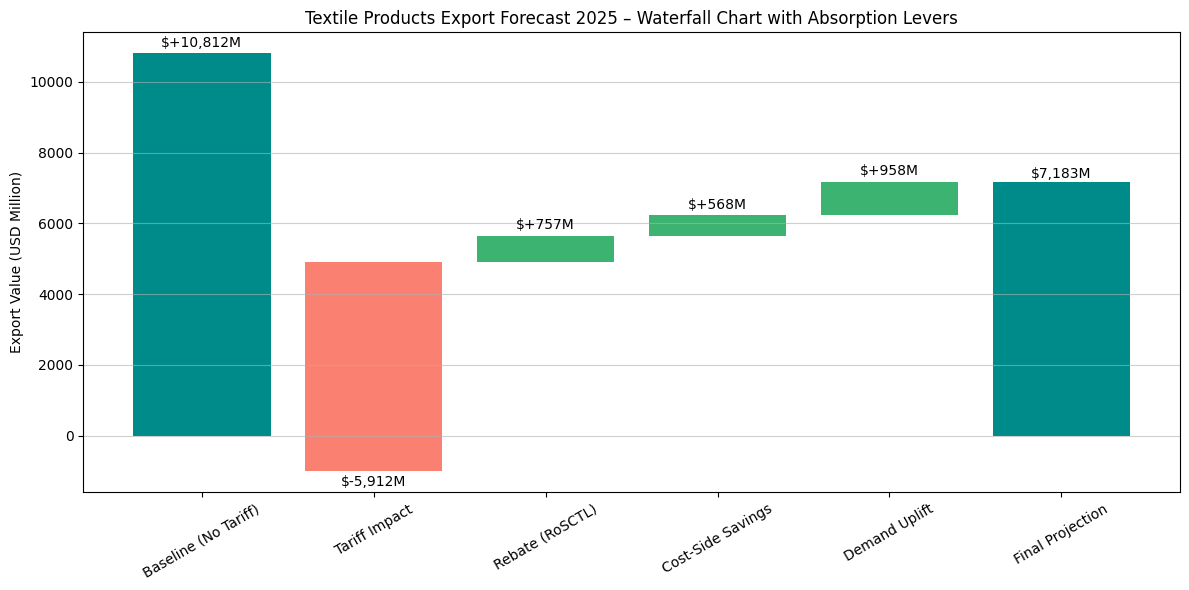

In [115]:
# Fix the IndexError: Make sure cumulative list matches values length

import matplotlib.pyplot as plt

# Example values for Base Case scenario for Textile Products
baseline_2025 = 10812.18     # No tariff
tariff_only = 4900.00        # Tariff-only impact
rebate_gain = 756.85         # RoSCTL ~7%
cost_savings_gain = 567.86   # Cost side reduction passed to buyer
demand_uplift_gain = 958.31  # Loyalty, bundling, etc.
final_projection = tariff_only + rebate_gain + cost_savings_gain + demand_uplift_gain

# Labels and values
labels = [
    "Baseline (No Tariff)",
    "Tariff Impact",
    "Rebate (RoSCTL)",
    "Cost-Side Savings",
    "Demand Uplift",
    "Final Projection"
]

values = [
    baseline_2025,
    -(baseline_2025 - tariff_only),  # Tariff loss
    rebate_gain,
    cost_savings_gain,
    demand_uplift_gain
]

# Calculate cumulative values
cumulative = [baseline_2025]
for val in values[1:]:
    cumulative.append(cumulative[-1] + val)

# Append final projection to values
values.append(0)  # for plotting height, not needed since final is in cumulative

# Colors
colors = ['darkcyan', 'salmon', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen', 'darkcyan']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(len(cumulative)):
    bottom = cumulative[i] if i > 0 and values[i] < 0 else cumulative[i] - values[i]
    ax.bar(labels[i], values[i], bottom=bottom, color=colors[i])
    ax.text(i, bottom + values[i] + (100 if values[i] > 0 else -100),
            f"${values[i]:+,.0f}M", ha='center', va='bottom' if values[i] > 0 else 'top')

# Final bar (solid)
ax.bar(labels[-1], cumulative[-1], color=colors[-1])
ax.text(len(labels)-1, cumulative[-1] + 100, f"${cumulative[-1]:,.0f}M", ha='center')

ax.set_title("Textile Products Export Forecast 2025 – Waterfall Chart with Absorption Levers")
ax.set_ylabel("Export Value (USD Million)")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='-', alpha=0.6)
plt.tight_layout()


